In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from LTH_helper import prune_and_initilize, get_prunned_model, initialize_sparse_model
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10, cifar100
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [3]:
my_dataset = cifar10

In [4]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images/255
y = train_labels.reshape(-1, 1)
if len(X.shape) == 3:
    X = X.reshape(*X.shape, 1)
X_test = test_images/255
y_test = test_labels.reshape(-1, 1)
if len(X_test.shape) == 3:
    X_test = X_test.reshape(*X_test.shape, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
output_size = np.max(y) + 1
input_shape = X_train.shape[1:]

In [5]:
X_train.shape, X_val.shape, X_test.shape, output_size, input_shape

((42500, 32, 32, 3), (7500, 32, 32, 3), (10000, 32, 32, 3), 10, (32, 32, 3))

In [14]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

def get_model(compile_model_flag=True, lr=0.001, activation='tanh', output_size = output_size, input_shape=input_shape):    
#     initializer = initializers.RandomNormal(mean=0, stddev=0.1)
#     initializer = initializers.glorot_uniform()
    initializer = initializers.VarianceScaling(1.0, mode='fan_avg')
    # Creo el modelo
    
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=input_shape, activation=activation, kernel_initializer=initializer))
    # model.add(MaxPool2D(2))
    model.add(Conv2D(64, 3, activation=activation, kernel_initializer=initializer))
    model.add(MaxPool2D(2))
    model.add(Conv2D(128, 3, activation=activation, kernel_initializer=initializer))
    # model.add(Conv2D(256, 3, activation=activation, kernel_initializer=initializer))
    #model.add(Conv2D(128, 3, activation=activation, kernel_initializer=initializer))
    model.add(Conv2D(64, 3, activation=activation, kernel_initializer=initializer))
    model.add(Conv2D(32, 3, activation=activation, kernel_initializer=initializer))
    model.add(Flatten())
    model.add(Dense(output_size, activation='softmax', name='Salida', kernel_initializer=initializer))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 10, 10, 64)        73792     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 32)          18464     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)           

In [15]:
def get_callbacks(filename):
    return [
        ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=np.sqrt(0.1), patience=10, verbose=0, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
    ]

In [16]:
def train_model(model, epochs = 10, batch_size = 1024):
    
    # Save initial weights
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
    model.save_weights(initial_filename)
    history = model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
               validation_data = (X_val, y_val),
               verbose=2, 
               callbacks=get_callbacks(best_filename)
              )
    model.load_weights(best_filename)
    act = model.get_config()['layers'][0]['config']['activation']
    print(f'{act}: {model.evaluate(X_test, y_test, verbose=0)}')
    del model
    return history

42/42 - 2s - loss: 1.8727 - accuracy: 0.3249 - val_loss: 1.6408 - val_accuracy: 0.4015 - lr: 0.0010
tanh: [1.63919997215271, 0.40720000863075256]


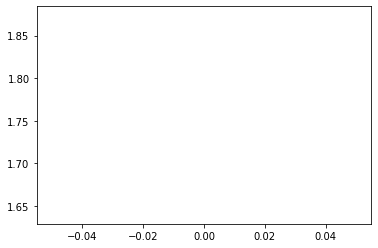

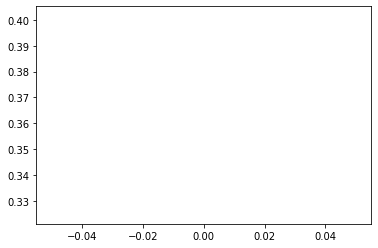

In [23]:
# activations = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu']
activation = 'tanh'
model = get_model(activation=activation)
history = train_model(model, epochs = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [24]:
def get_untrained_curve(activation):
    pms = np.linspace(0.001, 0.999, 50)
    accs_nt = []
    best_acc = 0
    if type(activation) == str:
        initial_filename = f'mlp.mnist.initial_weights_{activation}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation}.hdf5'
    else:
        initial_filename = f'mlp.mnist.initial_weights_{activation.__name__}.hdf5'
        best_filename = f'mlp.mnist.trained_weights_{activation.__name__}.hdf5'
        
    best_model = get_model(activation=activation)    
    best_model.load_weights(best_filename)
    for pm in pms:
        # print(model_pruned_layers.get_config()['layers'][0]['config']['layer']['config']['activation'])
        model_pruned_layers_not_trained = prune_and_initilize(best_model, pm, initial_filename)
        # print(model_pruned_layers_not_trained.get_config()['layers'][0]['config']['layer']['config']['activation'])
        actual_acc = model_pruned_layers_not_trained.evaluate(X_test, y_test, verbose=0)[1]
        print(actual_acc, pm)
        if actual_acc>best_acc:
            best_acc = actual_acc
            best_pm = pm
            model_pruned_layers_not_trained_best = strip_pruning(model_pruned_layers_not_trained)
        accs_nt.append(actual_acc)
    np.save(f'acc_not_train_prunned_{activation}_relu_20_epochs_normal_glorot_50.npy', [pms, accs_nt])
    model_pruned_layers_not_trained_best.save_weights(f'best_untrained_acc_{activation}_{int(best_pm*1000)/10}_{int(best_acc*1000)/10}.hdf5')
    return pms, accs_nt, best_pm, best_acc

0.10000000149011612 0.001
0.12129999697208405 0.02136734693877551
0.11320000141859055 0.04173469387755102
0.10679999738931656 0.06210204081632653
0.11190000176429749 0.08246938775510204
0.12189999967813492 0.10283673469387755
0.15809999406337738 0.12320408163265306
0.14800000190734863 0.14357142857142857
0.18780000507831573 0.16393877551020408
0.1551000028848648 0.1843061224489796
0.17110000550746918 0.2046734693877551
0.18170000612735748 0.2250408163265306
0.2872999906539917 0.24540816326530612
0.28540000319480896 0.26577551020408163
0.2590000033378601 0.28614285714285714
0.32420000433921814 0.30651020408163265
0.2597000002861023 0.32687755102040816
0.3107999861240387 0.3472448979591837
0.31790000200271606 0.3676122448979592
0.2757999897003174 0.3879795918367347
0.29429998993873596 0.4083469387755102
0.2678000032901764 0.4287142857142857
0.32760000228881836 0.4490816326530612
0.328000009059906 0.46944897959183673
0.3312000036239624 0.48981632653061224
0.30300000309944153 0.51018367346

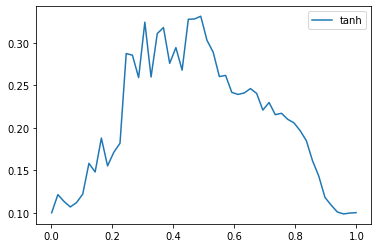

In [25]:
pms, accs_nt, best_pm, best_acc = get_untrained_curve(activation)
plt.plot(pms, accs_nt, label=f'{activation}')
plt.legend()
print(f'{activation}: {best_pm}, {best_acc}')